In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import torchvision

## Image Preprocessing

Each raw fundus image undergoes:
1. **Gray-background removal**
2. **Circular retina cropping**
3. **CLAHE contrast enhancement**
4. **Resizing → 224×224**

The processed images are saved into the final dataset folder: `datasets/preprocessed`



In [2]:
# Image size for preprocessing
IMG_SIZE = 512

# Preprocessing functions
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        if img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0] == 0:
            return img
        img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
        img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
        img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
        return np.stack([img1, img2, img3], axis=-1)

def circle_crop(img):
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    x, y = w//2, h//2
    r = min(x, y)
    mask = np.zeros((h, w), np.uint8)
    cv2.circle(mask, (x,y), r, 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=mask)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 10), -4, 128)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

def clahe_image(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    if len(img.shape) == 2 or img.shape[2] == 1:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        lab[:,:,0] = clahe.apply(lab[:,:,0])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

In [3]:
IMG_SIZE = 224  

# Paths
input_dirs = {
    "train": "datasets/unified_split/train",
    "val": "datasets/unified_split/val",
    "test": "datasets/unified_split/test"
}

output_dirs = {
    "train": "datasets/preprocessed/train",
    "val": "datasets/preprocessed/val",
    "test": "datasets/preprocessed/test"
}

# Folder → Label mapping
label_map = {"No_DR": 0, "DR": 1}

for split in ["train", "val", "test"]:
    for label in ["No_DR", "DR"]:
        os.makedirs(os.path.join(output_dirs[split], label), exist_ok=True)

    for label in os.listdir(input_dirs[split]):
        if label not in label_map:
            continue
        input_label_dir = os.path.join(input_dirs[split], label)
        output_label_dir = os.path.join(output_dirs[split], label)

        for img_file in tqdm(os.listdir(input_label_dir), desc=f"{split}/{label}"):
            img_path = os.path.join(input_label_dir, img_file)
            img = cv2.imread(img_path)
            img = circle_crop(img)
            img = clahe_image(img)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize during preprocessing
            save_path = os.path.join(output_label_dir, img_file)
            cv2.imwrite(save_path, img)


test/No_DR: 100%|████████████████████████████████████████████████████████████████████| 330/330 [01:16<00:00,  4.32it/s]


In [4]:
from torch.utils.data import Dataset

class DRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        label_map = {"No_DR": 0, "DR": 1}

        for label in os.listdir(root_dir):
            if label not in label_map:
                continue
            label_dir = os.path.join(root_dir, label)
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                self.images.append(img_path)
                self.labels.append(label_map[label])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load preprocessed image
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


## MobileNetV2 on Pre-processed Fundus Images

We use **MobileNetV2 pretrained on ImageNet** due to:
- High accuracy vs. model size balance
- Faster convergence for medical imaging datasets

Final classifier layer is modified:
- 2 output classes → `No_DR` (0) and `DR` (1)


In [5]:

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



In [6]:
train_dataset = DRDataset("datasets/preprocessed/train", transform=train_transform)
val_dataset   = DRDataset("datasets/preprocessed/val", transform=val_test_transform)
test_dataset  = DRDataset("datasets/preprocessed/test", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)  # Use 0 on Windows
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)



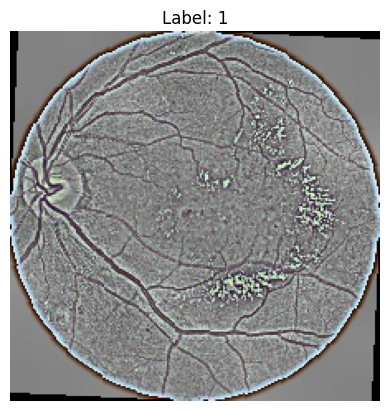

In [7]:

# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Pick the first image in the batch
img = images[0]  # tensor shape: [3, 224, 224]
label = labels[0].item()

# Convert tensor to NumPy for plotting
# Unnormalize first
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

img = img.permute(1, 2, 0).cpu().numpy()  # [H, W, C]
img = std * img + mean                     # unnormalize
img = np.clip(img, 0, 1)                  # clip values to [0,1]

plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [8]:
import torch.nn as nn


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MobileNetV2 pretrained model
model = models.mobilenet_v2(pretrained=True)

# Replace the classifier for 2 classes (No_DR, DR)
# MobileNetV2 has classifier as: model.classifier = nn.Sequential(...)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

# Move model to GPU/CPU
model = model.to(device)


D:\DR-Vision\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\DR-Vision\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [10]:
num_epochs = 10
best_acc = 0

for epoch in range(num_epochs):
    # === Training ===
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{len(train_loader)}] | Loss: {loss.item():.4f}", flush=True)

    # === Validation ===
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # === Save best model ===
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_mobilenetv2.pth")
        print(" Saved new best model")


Epoch [1/10] | Batch [1/633] | Loss: 0.5178
Epoch [1/10] | Batch [2/633] | Loss: 0.6895
Epoch [1/10] | Batch [3/633] | Loss: 0.5960
Epoch [1/10] | Batch [4/633] | Loss: 0.5669
Epoch [1/10] | Batch [5/633] | Loss: 0.4267
Epoch [1/10] | Batch [6/633] | Loss: 0.5738
Epoch [1/10] | Batch [7/633] | Loss: 0.4149
Epoch [1/10] | Batch [8/633] | Loss: 0.3953
Epoch [1/10] | Batch [9/633] | Loss: 0.3926
Epoch [1/10] | Batch [10/633] | Loss: 0.4118
Epoch [1/10] | Batch [11/633] | Loss: 0.3833
Epoch [1/10] | Batch [12/633] | Loss: 0.4478
Epoch [1/10] | Batch [13/633] | Loss: 0.2072
Epoch [1/10] | Batch [14/633] | Loss: 0.2867
Epoch [1/10] | Batch [15/633] | Loss: 0.3700
Epoch [1/10] | Batch [16/633] | Loss: 0.2342
Epoch [1/10] | Batch [17/633] | Loss: 0.2373
Epoch [1/10] | Batch [18/633] | Loss: 0.2097
Epoch [1/10] | Batch [19/633] | Loss: 0.1942
Epoch [1/10] | Batch [20/633] | Loss: 0.1178
Epoch [1/10] | Batch [21/633] | Loss: 0.6329
Epoch [1/10] | Batch [22/633] | Loss: 0.3509
Epoch [1/10] | Batc

###  Final Evaluation
We evaluate the enhanced model on the **test dataset**, giving the final:

In [12]:
# Load best model
model.load_state_dict(torch.load("best_mobilenetv2.pth"))
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(" Final Test Accuracy:", test_acc)


 Final Test Accuracy: 0.9592696629213483
